In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD

In [ ]:
training_data = pd.read_csv('train_expression.csv')
training_data = training_data.loc[:,:].values
training_data = pd.DataFrame(data = training_data)
training_labels = pd.read_csv('train_labels.csv')

test_data = pd.read_csv('test_expression.csv')
# test_data = pd.DataFrame(data = test_data)



In [17]:
# age_dist = pyplot.hist(training_labels, bins=10, range=[0,100], density = True)
# print(age_dist)
# training_data.min()

(965, 52935)


In [8]:
# print(training_data.shape)
# training_data_filtered = training_data.drop([col for col,val in (training_data.max()/(training_data.min()+1)).iteritems() if ( val<1000 )], axis=1, inplace = False)
# print(training_data_filtered.shape)
# training_data_filtered = training_data_filtered.drop([col for col,val in training_data_filtered.sum().iteritems() if ( val<0.05e10 )], axis=1, inplace = False)
# print(training_data_filtered.shape)

In [3]:
# Method to standardize data
def standardize_data(data):
    data_scaled = StandardScaler().fit_transform( data.transpose() )
    data_scaled = data_scaled.transpose()
    return data_scaled

# Method to get lda
def get_lda( data, labels, bins ):
    # Convert ages to bins
    label_lda = np.floor(np.array(labels).flatten()/bins)*bins
    # Convert data_scaled to np array
    data_lda = np.array(data)
    # Define LDA object
    lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage = 0.5,n_components=np.unique(label_lda).shape[0] - 1)
    # Get lda
    lda.fit(data_lda,label_lda)
    return lda

# Method to reduce dimentionality using lda
def reduce_feature_dimensions( data, lda ):
    data_lda_transformed = lda.transform(data)
    return np.array(data_lda_transformed)

In [ ]:
# Scale data
training_data_scaled = standardize_data(training_data)

bin_size = 5
lda = get_lda(training_data_scaled, training_labels, bin_size)

X = reduce_feature_dimensions(training_data_scaled, lda)
y = np.array(training_labels)

print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

In [11]:
# print(training_data.shape)
# training_data_filtered = training_data.drop([col for col,val in training_data.sum().iteritems() if ( val>2e10 )], axis=1, inplace = False)
# print(training_data_filtered.shape)
# training_data_filtered = training_data_filtered.drop([col for col,val in training_data_filtered.sum().iteritems() if ( val<0.05e10 )], axis=1, inplace = False)
# print(training_data_filtered.shape)

In [12]:
# PCA
# n_comp = 100;

# training_data_scaled = StandardScaler().fit_transform( training_data_filtered.transpose() )
# training_data_scaled = training_data_scaled.transpose()
# pca = PCA(n_components=n_comp)
# principalComponents = pca.fit_transform(training_data_scaled)
# training_data_pca = pd.DataFrame(data = principalComponents)
# sum(pca.explained_variance_ratio_)


In [13]:
# define n-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []
models = []
iteration = 1;
for train, valid in kfold.split(X, y):
    print( "\niteration : " + str(iteration))
    print( "--------------------------------------------------------------------")
    
    model = Sequential()
    model.add(Dense(1024, input_dim=X.shape[1], activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
    model.add(Dense(512, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
    model.add(Dense(256, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
    model.add(Dense(128, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
    model.add(Dense(1, activation='linear'))


    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit the keras model on the dataset
    model.fit(X[train], y[train], epochs=200, batch_size=32, verbose=0)

    # evaluate the model
    mse_train = model.evaluate(X[train], y[train], verbose=0)
    mse_valid = model.evaluate(X[valid], y[valid], verbose=0)
    print("MSE train" + " : " + str(mse_train))
    print("MSE valid" + " : " + str(mse_valid))
    
    cvscores.append(mse_valid)
    models.append(model)
    
    predictions_valid = model.predict(X[valid])
    a = pyplot.scatter(predictions_valid,y[valid])
    pyplot.savefig('PlotValid_'+str(iteration)+'.png')
    pyplot.close()
    predictions_train = model.predict(X[train])
    b = pyplot.scatter(predictions_train,y[train])
    pyplot.savefig('PlotTrain_'+str(iteration)+'.png')
    pyplot.close()

    iteration=iteration+1
print("\naverage MSE: %.2f (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

/software/python3/3.8.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"



iteration : 1
--------------------------------------------------------------------
MSE train : 41.1319580078125
MSE valid : 61.905433654785156

iteration : 2
--------------------------------------------------------------------
MSE train : 39.665897369384766
MSE valid : 68.30554962158203

iteration : 3
--------------------------------------------------------------------
MSE train : 41.25381851196289
MSE valid : 59.77855682373047

iteration : 4
--------------------------------------------------------------------
MSE train : 35.26085662841797
MSE valid : 69.2060775756836

iteration : 5
--------------------------------------------------------------------
MSE train : 42.845970153808594
MSE valid : 57.576961517333984

average MSE: 63.35 (+/- 4.63%)


In [14]:
# Train the model on full data

model = Sequential()
model.add(Dense(1024, input_dim=X.shape[1], activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
model.add(Dense(512, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
model.add(Dense(256, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
model.add(Dense(128, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error', optimizer='adam')

# fit the keras model on the dataset
model.fit(X, y, epochs=200, batch_size=32, verbose=0)

# evaluate the model
mse_train = model.evaluate(X, y, verbose=0)
print("MSE train" + " : " + str(mse_train))

MSE train : 35.65270233154297


In [23]:
# plot loss during training
# pyplot.title('Loss / Mean Squared Error')
# pyplot.plot(model_op.history['loss'], label='train')
# pyplot.plot(model_op.history['val_loss'], label='validation')
# pyplot.legend()
# pyplot.show()

In [18]:
test_data_scaled = standardize_data(test_data)
X_test = reduce_feature_dimensions(test_data_scaled, lda)

print(X_test.shape)
print(type(X_test))

(965, 14)
<class 'numpy.ndarray'>


In [24]:
predictions_test = model.predict(X_test)
print(predictions_test)
np.savetxt("predictions.csv", predictions_test, delimiter=",")

[[55.423286]
 [48.33906 ]
 [49.76531 ]
 [49.190517]
 [52.657963]
 [63.898983]
 [54.794216]
 [53.66583 ]
 [51.848133]
 [44.16071 ]
 [44.11732 ]
 [55.39105 ]
 [54.660824]
 [50.05015 ]
 [43.91145 ]
 [64.47136 ]
 [69.64993 ]
 [63.977207]
 [34.803036]
 [57.26411 ]
 [60.75851 ]
 [39.614395]
 [53.42233 ]
 [54.168484]
 [52.82722 ]
 [56.90299 ]
 [18.402084]
 [70.30452 ]
 [31.965965]
 [58.52804 ]
 [60.005917]
 [79.02518 ]
 [73.545456]
 [51.598396]
 [62.370228]
 [61.316654]
 [58.90378 ]
 [68.17232 ]
 [33.390972]
 [51.54509 ]
 [80.43532 ]
 [43.524723]
 [68.75196 ]
 [66.5289  ]
 [54.210705]
 [65.84421 ]
 [67.04291 ]
 [43.714886]
 [44.166813]
 [56.210335]
 [65.69247 ]
 [57.55129 ]
 [76.86505 ]
 [64.3639  ]
 [51.63239 ]
 [75.49848 ]
 [54.01972 ]
 [68.84008 ]
 [52.855457]
 [52.982327]
 [61.953045]
 [36.33672 ]
 [62.717003]
 [44.3911  ]
 [39.566006]
 [74.42906 ]
 [50.356396]
 [61.410076]
 [55.60275 ]
 [53.8364  ]
 [45.78554 ]
 [45.40227 ]
 [45.06972 ]
 [52.254726]
 [50.41611 ]
 [35.427464]
 [63.72685 ]

(array([  2.,   3.,   8.,  34.,  91., 194., 234., 234., 117.,  48.]),
 array([ 4.308786, 11.964444, 19.620102, 27.275759, 34.931416, 42.587074,
        50.242733, 57.89839 , 65.55405 , 73.20971 , 80.865364],
       dtype=float32),
 <BarContainer object of 10 artists>)

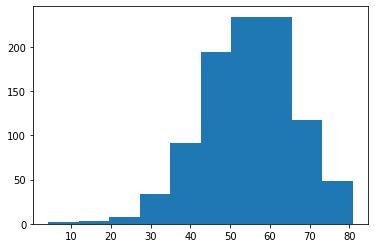

In [23]:
pyplot.hist(predictions_test)